# Usage 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pertpy
from deres import DEResult
import scanpy as sc
import numpy as np
import pandas as pd

/home/sturm/projects/scverse/deres/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Build example dataset

For the sake of this example, we just go with the `pbmc3k` dataset and assign a random sample identifier to
each cell to mimick a multi-sample dataset. 

In [3]:
adata = sc.datasets.pbmc3k_processed()
adata.obs["sample"] = pd.Categorical([f"sample_{x}" for x in np.random.randint(0, 10, adata.shape[0])])
# raw.X contains log-normalized values which we are going to use here
adata = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

## Run differential expression testing

We first contruct a pseudobulk-object and then use the statsmodels implementation in pertpy to 
compare gene expression between cell-types. For the sake of the example, we
compare CD8+ T cells with CD4+ T cells and NK cells. 

In [4]:
pb = sc.get.aggregate(adata, ["sample", "louvain"], "mean")

In [5]:
mod = pertpy.tl.Statsmodels(pb, design="~ louvain", layer="mean")
mod.fit()

  0%|                                                                                                                                                                                                                                                                                    | 0/13714 [00:00<?, ?it/s]

  1%|██▍                                                                                                                                                                                                                                                                     | 129/13714 [00:00<00:10, 1280.34it/s]

  2%|████▉                                                                                                                                                                                                                                                                   | 258/13714 [00:00<00:10, 1269.51it/s]

  3%|███████▍                                                                                                                                                                                                                                                                | 385/13714 [00:00<00:10, 1265.16it/s]

  4%|█████████▊                                                                                                                                                                                                                                                              | 512/13714 [00:00<00:10, 1266.79it/s]

  5%|████████████▎                                                                                                                                                                                                                                                           | 641/13714 [00:00<00:10, 1273.67it/s]

  6%|██████████████▊                                                                                                                                                                                                                                                         | 770/13714 [00:00<00:10, 1276.96it/s]

  7%|█████████████████▎                                                                                                                                                                                                                                                      | 898/13714 [00:00<00:10, 1273.38it/s]

  7%|███████████████████▋                                                                                                                                                                                                                                                   | 1026/13714 [00:00<00:09, 1269.82it/s]

  8%|██████████████████████                                                                                                                                                                                                                                                 | 1153/13714 [00:00<00:09, 1265.53it/s]

  9%|████████████████████████▌                                                                                                                                                                                                                                              | 1280/13714 [00:01<00:09, 1266.27it/s]

 10%|███████████████████████████                                                                                                                                                                                                                                            | 1408/13714 [00:01<00:09, 1269.11it/s]

 11%|█████████████████████████████▍                                                                                                                                                                                                                                         | 1535/13714 [00:01<00:09, 1236.98it/s]

 12%|███████████████████████████████▊                                                                                                                                                                                                                                       | 1659/13714 [00:01<00:09, 1216.55it/s]

 13%|██████████████████████████████████▏                                                                                                                                                                                                                                    | 1783/13714 [00:01<00:09, 1221.65it/s]

 14%|████████████████████████████████████▌                                                                                                                                                                                                                                  | 1906/13714 [00:01<00:09, 1187.10it/s]

 15%|██████████████████████████████████████▊                                                                                                                                                                                                                                | 2025/13714 [00:01<00:10, 1156.93it/s]

 16%|█████████████████████████████████████████▏                                                                                                                                                                                                                             | 2150/13714 [00:01<00:09, 1181.60it/s]

 17%|███████████████████████████████████████████▋                                                                                                                                                                                                                           | 2277/13714 [00:01<00:09, 1204.62it/s]

 18%|██████████████████████████████████████████████                                                                                                                                                                                                                         | 2404/13714 [00:01<00:09, 1221.60it/s]

 18%|████████████████████████████████████████████████▌                                                                                                                                                                                                                      | 2531/13714 [00:02<00:09, 1234.95it/s]

 19%|██████████████████████████████████████████████████▉                                                                                                                                                                                                                    | 2658/13714 [00:02<00:08, 1244.00it/s]

 20%|█████████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 2786/13714 [00:02<00:08, 1252.46it/s]

 21%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 2915/13714 [00:02<00:08, 1260.81it/s]

 22%|██████████████████████████████████████████████████████████▎                                                                                                                                                                                                            | 3042/13714 [00:02<00:08, 1260.55it/s]

 23%|████████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 3169/13714 [00:02<00:08, 1261.93it/s]

 24%|███████████████████████████████████████████████████████████████▏                                                                                                                                                                                                       | 3296/13714 [00:02<00:08, 1264.31it/s]

 25%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                     | 3423/13714 [00:02<00:08, 1265.01it/s]

 26%|████████████████████████████████████████████████████████████████████                                                                                                                                                                                                   | 3550/13714 [00:02<00:08, 1266.29it/s]

 27%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                | 3677/13714 [00:02<00:07, 1265.87it/s]

 28%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                              | 3804/13714 [00:03<00:07, 1260.74it/s]

 29%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 3931/13714 [00:03<00:08, 1200.64it/s]

 30%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                         | 4052/13714 [00:03<00:08, 1163.22it/s]

 30%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                       | 4169/13714 [00:03<00:08, 1141.57it/s]

 31%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                    | 4284/13714 [00:03<00:08, 1124.64it/s]

 32%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 4397/13714 [00:03<00:08, 1113.86it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                 | 4509/13714 [00:03<00:12, 743.78it/s]

 34%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                               | 4619/13714 [00:03<00:11, 819.77it/s]

 34%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                             | 4729/13714 [00:04<00:10, 883.62it/s]

 35%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 4859/13714 [00:04<00:08, 987.76it/s]

 36%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 4969/13714 [00:04<00:08, 1017.22it/s]

 37%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 5079/13714 [00:04<00:08, 1038.34it/s]

 38%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                   | 5205/13714 [00:04<00:07, 1100.15it/s]

 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                | 5333/13714 [00:04<00:07, 1151.15it/s]

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                              | 5461/13714 [00:04<00:06, 1188.02it/s]

 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 5590/13714 [00:04<00:06, 1215.77it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                         | 5719/13714 [00:04<00:06, 1237.40it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 5848/13714 [00:04<00:06, 1250.78it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 5977/13714 [00:05<00:06, 1261.61it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 6104/13714 [00:05<00:06, 1211.10it/s]

 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                               | 6238/13714 [00:05<00:05, 1248.22it/s]

 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 6364/13714 [00:05<00:06, 1208.59it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 6486/13714 [00:05<00:06, 1179.11it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 6605/13714 [00:05<00:06, 1157.77it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 6722/13714 [00:05<00:06, 1142.17it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                    | 6837/13714 [00:05<00:06, 1130.45it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 6951/13714 [00:05<00:06, 1125.25it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 7064/13714 [00:06<00:05, 1121.42it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 7185/13714 [00:06<00:05, 1146.81it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 7319/13714 [00:06<00:05, 1202.09it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 7450/13714 [00:06<00:05, 1232.57it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 7574/13714 [00:06<00:05, 1195.53it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 7700/13714 [00:06<00:04, 1211.25it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 7822/13714 [00:06<00:04, 1209.90it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 7944/13714 [00:06<00:04, 1179.16it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 8063/13714 [00:06<00:04, 1169.70it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 8196/13714 [00:06<00:04, 1213.73it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 8318/13714 [00:07<00:04, 1210.55it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 8444/13714 [00:07<00:04, 1223.92it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 8570/13714 [00:07<00:04, 1233.34it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 8694/13714 [00:07<00:04, 1187.08it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 8814/13714 [00:07<00:04, 1161.30it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 8931/13714 [00:07<00:04, 1143.94it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 9046/13714 [00:07<00:04, 1133.10it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 9160/13714 [00:07<00:04, 1125.87it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 9273/13714 [00:07<00:03, 1120.15it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 9386/13714 [00:08<00:03, 1115.25it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 9498/13714 [00:08<00:03, 1113.49it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 9615/13714 [00:08<00:03, 1129.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 9728/13714 [00:08<00:03, 1128.54it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 9841/13714 [00:08<00:03, 1121.36it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 9959/13714 [00:08<00:03, 1137.81it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 10092/13714 [00:08<00:03, 1194.62it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 10225/13714 [00:08<00:02, 1233.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 10358/13714 [00:08<00:02, 1261.68it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 10492/13714 [00:08<00:02, 1282.81it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 10625/13714 [00:09<00:02, 1294.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 10757/13714 [00:09<00:02, 1301.30it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 10888/13714 [00:09<00:02, 1301.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 11021/13714 [00:09<00:02, 1307.48it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 11153/13714 [00:09<00:01, 1310.81it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 11286/13714 [00:09<00:01, 1316.41it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 11418/13714 [00:09<00:01, 1313.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 11551/13714 [00:09<00:01, 1315.90it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 11684/13714 [00:09<00:01, 1318.29it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 11816/13714 [00:09<00:01, 1318.59it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 11949/13714 [00:10<00:01, 1319.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 12082/13714 [00:10<00:01, 1320.09it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 12215/13714 [00:10<00:01, 1317.11it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 12347/13714 [00:10<00:01, 799.23it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 12474/13714 [00:10<00:01, 895.66it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 12602/13714 [00:10<00:01, 981.85it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 12724/13714 [00:10<00:00, 1039.84it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 12848/13714 [00:10<00:00, 1090.19it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 12977/13714 [00:11<00:00, 1141.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 13100/13714 [00:11<00:00, 1110.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 13217/13714 [00:11<00:00, 1099.75it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 13338/13714 [00:11<00:00, 1128.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 13460/13714 [00:11<00:00, 1152.79it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 13582/13714 [00:11<00:00, 1170.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 13701/13714 [00:11<00:00, 1124.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13714/13714 [00:11<00:00, 1172.89it/s]

In [6]:
res = mod.test_contrasts(
    {
        "CD8_vs_CD4": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="CD4 T cells"),
        "CD8_vs_NK": mod.cond(louvain="CD8 T cells") - mod.cond(louvain="NK cells"),
    }
)
res["p_value"] = res["p_value"].astype(float)  # don't ask me why this is an object column

  0%|                                                                                                                                                                                                                                                                                    | 0/13714 [00:00<?, ?it/s]

  8%|█████████████████████▎                                                                                                                                                                                                                                                | 1113/13714 [00:00<00:01, 11121.82it/s]

 16%|██████████████████████████████████████████▌                                                                                                                                                                                                                           | 2226/13714 [00:00<00:01, 10990.15it/s]

 25%|████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                     | 3377/13714 [00:00<00:00, 11222.84it/s]

 33%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                               | 4531/13714 [00:00<00:00, 11345.14it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 5666/13714 [00:00<00:00, 11317.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 6798/13714 [00:00<00:00, 10967.10it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 7939/13714 [00:00<00:00, 11106.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 9052/13714 [00:00<00:00, 11098.51it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 10170/13714 [00:00<00:00, 11120.72it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 11294/13714 [00:01<00:00, 11154.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 12419/13714 [00:01<00:00, 11183.34it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 13538/13714 [00:01<00:00, 11181.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13714/13714 [00:01<00:00, 11145.57it/s]

  0%|                                                                                                                                                                                                                                                                                    | 0/13714 [00:00<?, ?it/s]

  9%|████████████████████████                                                                                                                                                                                                                                              | 1257/13714 [00:00<00:00, 12568.78it/s]

 18%|████████████████████████████████████████████████▎                                                                                                                                                                                                                     | 2530/13714 [00:00<00:00, 12662.82it/s]

 28%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 3797/13714 [00:00<00:00, 12496.95it/s]

 37%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 5047/13714 [00:00<00:00, 12416.08it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 6289/13714 [00:00<00:00, 12310.39it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 7521/13714 [00:00<00:00, 12271.71it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 8749/13714 [00:00<00:00, 12264.99it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 9990/13714 [00:00<00:00, 12308.26it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 11332/13714 [00:00<00:00, 12653.83it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 12618/13714 [00:01<00:00, 12715.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13714/13714 [00:01<00:00, 12582.26it/s]

In [7]:
res

,variable,p_value,t_value,sd,log_fc,adj_p_value,contrast
3694,GZMK,2.703991e-38,2.689104e+01,0.026700,7.179881e-01,2.703991e-38,CD8_vs_CD4
11083,CCL5,2.549464e-33,2.235275e+01,0.080934,1.809106e+00,2.549464e-33,CD8_vs_CD4
9292,GZMH,5.377138e-31,2.044751e+01,0.029001,5.930062e-01,5.377138e-31,CD8_vs_CD4
13001,NKG7,2.996402e-30,1.986191e+01,0.088122,1.750264e+00,2.996402e-30,CD8_vs_CD4
3695,GZMA,2.014626e-26,1.703723e+01,0.048890,8.329481e-01,2.014626e-26,CD8_vs_CD4
...,...,...,...,...,...,...,...
3098,PIGZ,1.000000e+00,-9.221825e-17,0.004703,-4.336809e-19,1.000000e+00,CD8_vs_NK
2663,HESX1,1.000000e+00,9.988825e-17,0.004342,4.336809e-19,1.000000e+00,CD8_vs_NK
7952,CCND1,1.000000e+00,0.000000e+00,0.004221,0.000000e+00,1.000000e+00,CD8_vs_NK
1505,TP53I3,1.000000e+00,0.000000e+00,0.012417,0.000000e+00,1.000000e+00,CD8_vs_NK


## Construct DEResult class

DEResult is class that holds a dataframe with DE results and associated metadata (e.g. which columns to use).
The DEResult instance then provides summary and plotting functions to investigate the differential expression results.

In [8]:
de_res = DEResult(
    res, pb, p_col="p_value", effect_size_col="log_fc", var_col="variable", contrast_col="contrast", layer="mean"
)

In [9]:
de_res.summary()

,total,up,down,contrast
p < 0.1,1004,388,616,CD8_vs_CD4
p < 0.05,720,254,466,CD8_vs_CD4
p < 0.01,435,126,309,CD8_vs_CD4
p < 0.001,275,72,203,CD8_vs_CD4
p < 0.0001,153,45,108,CD8_vs_CD4
p < 0.1,1833,894,939,CD8_vs_NK
p < 0.05,1168,581,587,CD8_vs_NK
p < 0.01,632,317,315,CD8_vs_NK
p < 0.001,321,163,158,CD8_vs_NK
p < 0.0001,186,82,104,CD8_vs_NK


We can use `.p_adjust` to apply FDR correction of the p-values. It adds another column with the adjusted p-values
to the results data frame and updates the pointer of the p-value column to use to use the FDR-adjusted p-values. 

As a result, we can see in the summary DF, that now a lot fewer genes are considered significant at the different 
thresholds. 

In [10]:
de_res.p_adjust()

In [11]:
de_res.summary()

,total,up,down,contrast
p < 0.1,323,85,238,CD8_vs_CD4
p < 0.05,280,72,208,CD8_vs_CD4
p < 0.01,158,48,110,CD8_vs_CD4
p < 0.001,94,35,59,CD8_vs_CD4
p < 0.0001,68,29,39,CD8_vs_CD4
p < 0.1,421,207,214,CD8_vs_NK
p < 0.05,331,166,165,CD8_vs_NK
p < 0.01,196,87,109,CD8_vs_NK
p < 0.001,124,51,73,CD8_vs_NK
p < 0.0001,85,29,56,CD8_vs_NK


## Use plotting functions

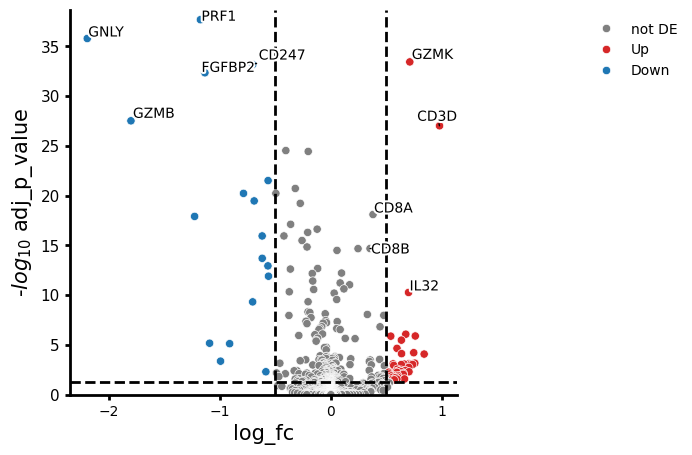

In [12]:
de_res.plot_volcano("CD8_vs_NK", log2fc_thresh=0.5)

Index(['CD8 T cells', 'NK cells'], dtype='object')


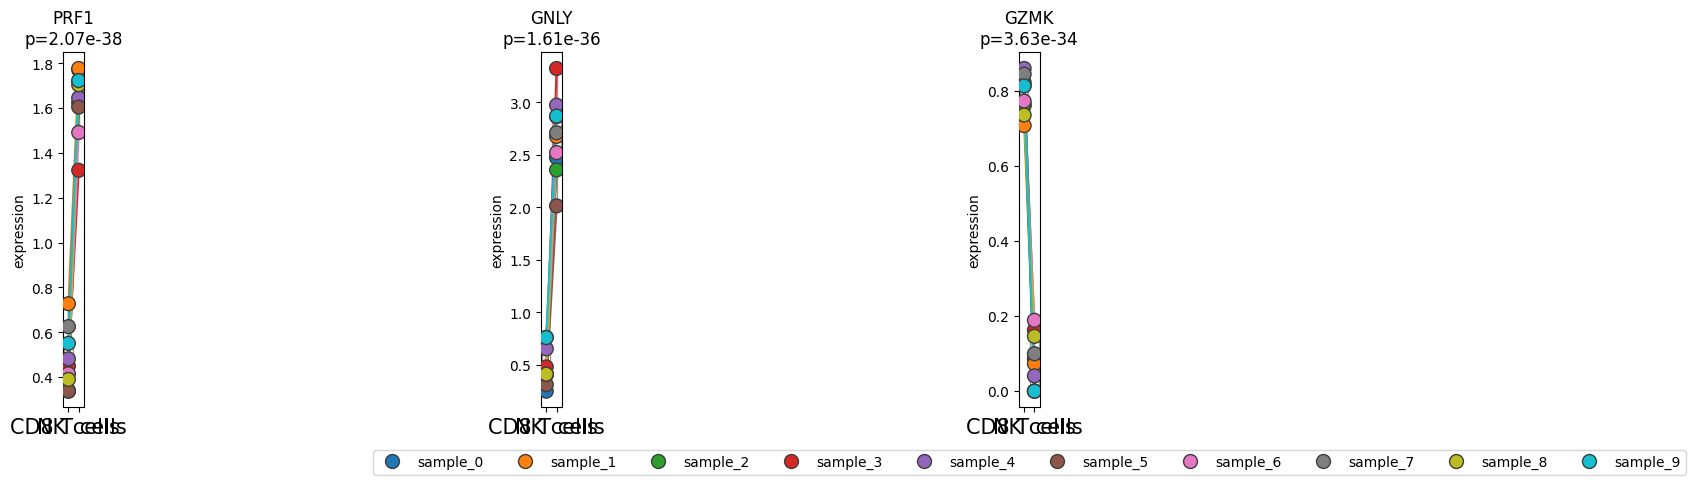

In [13]:
de_res.plot_paired("louvain", "sample", "CD8_vs_NK", groups=["CD8 T cells", "NK cells"], n_top_vars=3)

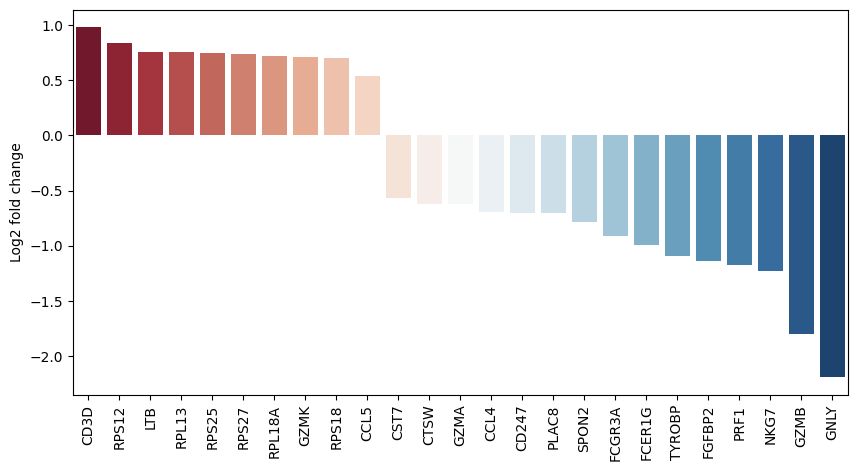

In [14]:
de_res.plot_fold_change("CD8_vs_NK")

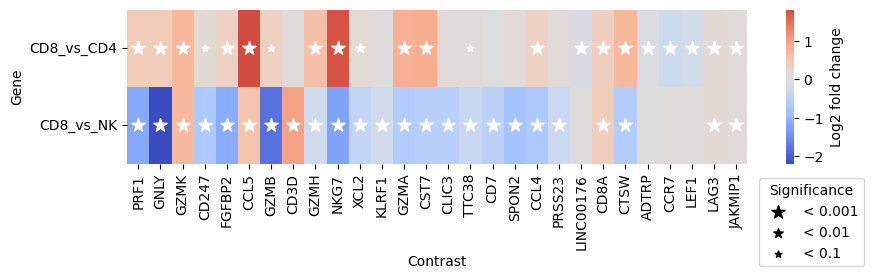

In [15]:
de_res.plot_multicomparison_fc()